In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Load Feature Data:

In [4]:
# File path
file_path = 'features_batch_2.csv'  # Replace with your actual file path

# Load the data
data = np.loadtxt(file_path, delimiter=',')

# Split the data into features and normalize
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Split into train and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(normalized_data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_dataset = torch.FloatTensor(train_data)
val_dataset = torch.FloatTensor(val_data)

# Print shapes to verify
print(f"Training set shape: {train_dataset.shape}")
print(f"Validation set shape: {val_dataset.shape}")

# Save the datasets (optional)
torch.save(train_dataset, 'train_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')

# If you want to save the scaler for later use (e.g., for test data or new data)
import joblib
joblib.dump(scaler, 'scaler.pkl')

print("Data preparation completed!")

Training set shape: torch.Size([276797, 78])
Validation set shape: torch.Size([69200, 78])
Data preparation completed!


# Define Encoder

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_log_var = nn.Linear(32, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_log_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Initialise parameters

In [14]:
# Hyperparameters
input_dim = 78  # 8 features * 6 bands
latent_dim = 16
batch_size = 128
num_epochs = 200
learning_rate = 1e-3

# Initialize the VAE
model = VAE(input_dim, latent_dim)

# Loss function
def loss_function(recon_x, x, mu, log_var):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare the data
train_loader = DataLoader(TensorDataset(train_dataset), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_dataset), batch_size=batch_size)


# Training

In [16]:
# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0]
            recon_batch, mu, log_var = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, log_var)
            val_loss += loss.item()
            
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), 'lsst_vae.pth')

Epoch [1/200], Train Loss: 3665.6408, Val Loss: 3658.5398
Epoch [2/200], Train Loss: 12115.0289, Val Loss: 3534.9355
Epoch [3/200], Train Loss: 3531.6335, Val Loss: 3361.6501
Epoch [4/200], Train Loss: 3458.7354, Val Loss: 3562.4639
Epoch [5/200], Train Loss: 3513.4946, Val Loss: 3790.9308
Epoch [6/200], Train Loss: 3386.3877, Val Loss: 3084.1491
Epoch [7/200], Train Loss: 3298.3419, Val Loss: 3196.7371
Epoch [8/200], Train Loss: 3216.8276, Val Loss: 3125.8000
Epoch [9/200], Train Loss: 3191.6467, Val Loss: 3090.5800
Epoch [10/200], Train Loss: 3178.8302, Val Loss: 3319.0466
Epoch [11/200], Train Loss: 123888.6998, Val Loss: 7666.5212
Epoch [12/200], Train Loss: 3304.0970, Val Loss: 2992.0849
Epoch [13/200], Train Loss: 3095.3137, Val Loss: 2808.7180
Epoch [14/200], Train Loss: 2981.5341, Val Loss: 2730.1658
Epoch [15/200], Train Loss: 3976.3825, Val Loss: 3259.3958
Epoch [16/200], Train Loss: 107393.0432, Val Loss: 3198.5136
Epoch [17/200], Train Loss: 3144.7257, Val Loss: 2917.9410
E

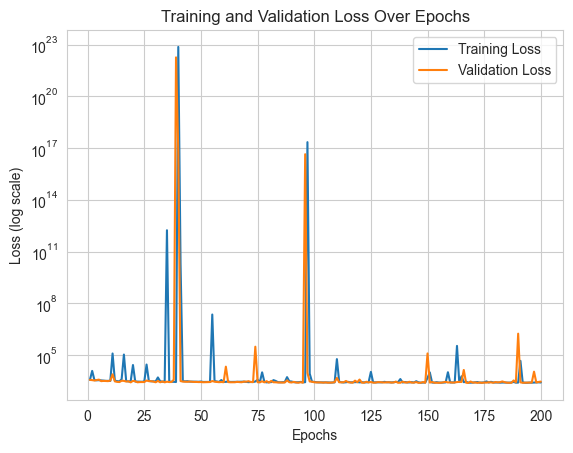

Training completed and loss plot saved as 'vae_training_loss.png'


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Plotting function
def plot_losses(train_losses, val_losses):
    # plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.yscale('log')  # Set y-axis to log scale
    plt.grid(True)
    plt.savefig('vae_training_loss.png')
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

print("Training completed and loss plot saved as 'vae_training_loss.png'")

In [21]:
# Using the trained model for encoding
def encode_data(model, data):
    model.eval()
    with torch.no_grad():
        mu, log_var = model.encode(data)
        z = model.reparameterize(mu, log_var)
    return z

# Load the trained model
loaded_model = VAE(input_dim, latent_dim)
loaded_model.load_state_dict(torch.load('lsst_vae.pth'))

# Encode the test dataset
encoded_test = encode_data(loaded_model, val_dataset)

print("Shape of encoded test data:", encoded_test.shape)

# Generate new samples
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = model.decode(z)
    return samples

new_samples = generate_samples(loaded_model, 10)
print("Shape of generated samples:", new_samples.shape)

Shape of encoded test data: torch.Size([69200, 16])
Shape of generated samples: torch.Size([10, 78])


/var/folders/j1/2fc026fn1yd35x1ljyjz6k600000gn/T/ipykernel_22061/3848651775.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('lss